# LSI31003 Machine Learning in Molecular Biology Assignment 1

In [2]:
# Loading modules
library(ggplot2)
library(rBeta2009)
library(grid)
library(repr)
library(reshape2)
library(Rmisc)
library(ggpmisc)
library(gplots)
library(pastecs)


##  Introduction <a id='section1'></a>

Here we will explore a somatic mutation data set from ["Alexandrov LB, et al. (2013) Signatures of mutational processes in human cancer. Nature 500(7463):415–421"](https://www.nature.com/articles/nature12477). 

In [3]:
## Import data:
data_path<-"/Users/qingli/Desktop/Course/MLinMolecularBiology/Exercise/data/"
channels96<-paste(data_path,"MutSigCancer/channels96.csv",sep="")
channels96<-read.csv(channels96)

somatic<-paste(data_path,"MutSigCancer/somaticMutations.csv",sep="")
somaticMutations<-read.csv(somatic)

cosmic<-paste(data_path,"MutSigCancer/cosmic30.csv",sep="")
cosmic30<-read.csv(cosmic)

## change the colunm names of somaticMutations(because those like "@|>" are converted into "." by python):
colnames(somaticMutations)<-c("cancer_type",as.character(channels96$mutation))

## head of the data files:
head(channels96,2)
tail(somaticMutations,2)
head(cosmic30,2)


mutation.type,mutation.context,mutation
C>A,A_A,C>A@A_A
C>A,A_C,C>A@A_C


,cancer_type,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,⋯,T>G@C_G,T>G@C_T,T>G@G_A,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T
7015,Uterus,1,1,1,0,2,0,0,0,1,⋯,0,1,0,0,0,0,0,0,0,0
7016,Uterus,1,0,3,0,1,1,0,1,0,⋯,1,0,0,0,1,1,0,0,0,0


X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0.0110983262,0.0091493407,1.490070e-03,0.0062338852,0.006595870,0.007342368,8.928404e-04,0.0071865816,0.0082326040,0.0057580214,⋯,0.0015995485,2.758538e-03,9.904500e-05,2.023656e-04,0.0011883532,8.007233e-04,1.397554e-03,1.291737e-03,0.0020310769,0.0040301282
0.0006827082,0.0006191072,9.927896e-05,0.0003238914,0.000677445,0.000213681,6.770460e-06,0.0004163329,0.0003520134,0.0001338169,⋯,0.0002282459,6.711134e-05,9.555239e-05,4.700238e-05,0.0001099257,8.647718e-05,7.173695e-05,1.428146e-05,0.0002066152,0.0000235982


### Problem 1: Explore the data in various ways by visualisation as well as summary statistics <a id='Problem1'></a>

#### Problem 1a: 
Using the data matrix somaticMutations make a summary plot of total number of mutations per sample per cancer type, see for reference Figure 1 in Alexandrov et al. Nature 2013. 

From the paper, there are "7,042 primary cancers of 30 different classes (507 from whole genome and 6,535 from exome sequences)"

[1] "Cut off vaule for total count in WES vs. WGS "


[1] 1145

[1] "Number of samples belongs to WES sample"


[1] 6510

[1] "Number of samples belongs to WGS sample"


[1] 506

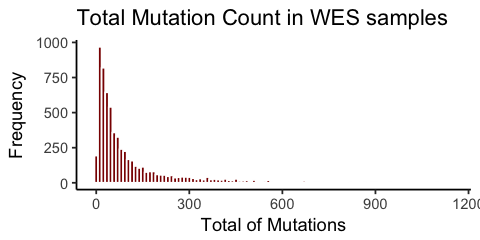

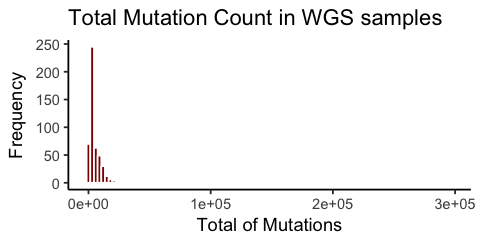

In [7]:
## sum each row and add the total number as the new colunm of somaticMutations named by "name":
somaticMutations$total<-as.numeric(apply(somaticMutations[,2:97],1,function(x) sum(x)))

## based on the paper, there are 507 WGS samples, here I assume the total count of SNVs in WGS is higher than WES
cutoff<-head(tail(sort(somaticMutations$total),507),1)
print ("Cut off vaule for total count in WES vs. WGS ")
cutoff

WES_index<-somaticMutations$total<=cutoff
WGS_index<-somaticMutations$total>cutoff
    
print ("Number of samples belongs to WES sample")
sum(WES_index)

print ("Number of samples belongs to WGS sample")
sum(WGS_index)

## Histogram plot of SNV total count in WES
options(repr.plot.width=4, repr.plot.height=2)
plot<-ggplot(data=somaticMutations[WES_index,],aes(x=total))
plot<-plot+geom_histogram(bins=100,col="white",fill="red4")+theme_classic()
plot+xlab("Total of Mutations")+ylab("Frequency")+
    ggtitle("Total Mutation Count in WES samples")

## Histogram plot of SNV total count in WGS
plot<-ggplot(data=somaticMutations[WGS_index,],aes(x=total))
plot<-plot+geom_histogram(bins=100,col="white",fill="red4")+theme_classic()
plot<-plot+xlab("Total of Mutations")+ylab("Frequency")+
plot+ggtitle("Total Mutation Count in WGS samples")


In [9]:
## Get the mutational rate per Mb
## dividing total count in the WES samples by 30 Mb, and that of WGS samples by 3000Mb
somaticMutations$MutationalRate<-rep(NA,dim(somaticMutations)[1])

somaticMutations$MutationalRate[WES_index]<-log(somaticMutations$total[WES_index]/3)
somaticMutations$MutationalRate[WGS_index]<-log(somaticMutations$total[WGS_index]/3000)

In [18]:
## get the uniq cancer types from somaticMutations
cancers<-somaticMutations$cancer_type
cancer_uniq<-unique(cancers)
## x axis labels:
new_x_labels<-as.character(cancer_uniq)

## for each cancer type, calculate the total SNVs and sort the data by the mutational rate which is the order
## shown on the following figure:

cancer_types_num<-length(cancer_uniq)
total_snvs<-NULL
median_snvs<-NULL
for (i in 1:cancer_types_num){
    cancer_logical_index<-somaticMutations$cancer_type == cancer_uniq[i]
    total_snvs<-c(total_snvs,sum(cancer_logical_index))
    median_snvs<-c(median_snvs,median(somaticMutations$MutationalRate[cancer_logical_index]))
}
summary_data<-data.frame(cancer_type=cancer_uniq,total_snvs=total_snvs,median_snvs=median_snvs)
##summary_data[which.max(summary_data$total_snvs),]
summary_data<-summary_data[with(summary_data, order(median_snvs)),]
ordered_cancer_type<-as.vector(summary_data$cancer_type)
"Top 6 six cancer types with lowest mutation rate:"
head(summary_data)

[1] "Top 6 six cancer types with lowest mutation rate:"

,cancer_type,total_snvs,median_snvs
1,ALL,137,0.9808293
19,LymphomaB-cell,48,1.0299382
15,Liver,88,1.0435688
2,AML,154,1.2039728
12,KidneyChromophobe,65,1.2039728
5,CLL,131,1.5404450


In [16]:
## reshape the data for ploting:
sorted_MR<-NULL
sorted_cancer_name<-NULL
order<-NULL
for (i in 1:length(ordered_cancer_type)){
    cancer_logical_index<-somaticMutations$cancer_type == ordered_cancer_type[i]   
    sorted_mr_per_cancer<-sort(somaticMutations$MutationalRate[cancer_logical_index])
    sorted_MR<-c(sorted_MR,sorted_mr_per_cancer)
    sorted_cancer_name<-c(sorted_cancer_name,rep(ordered_cancer_type[i],sum(cancer_logical_index)))
    upperhalf<-round(sum(cancer_logical_index)/2)
    lowerhalf<-sum(cancer_logical_index)-upperhalf
    order_upper<-(500-upperhalf+1):500
    order_lower<-501:(500+lowerhalf)
    order<-as.numeric(c(order,order_upper,order_lower))
#    median_snvs<-c(median_snvs_all,rep(summary_data$median_snvs[summary_data$cancer_type==ordered_cancer_type[i]],sum(cancer_logical_index))
}

## add a new colunm to somaticMutations for ordering. 
##Otherwise the dot of the plot will be displayed in the same position
somaticMutations$order<-order
plot_data<-data.frame(cancer_type=sorted_cancer_name,order=order,sorted_MR=sorted_MR)

plot_data$cancer_order<-factor(plot_data$cancer_type,levels=as.vector(summary_data$cancer_type))
#cancer_order
plot_data<-merge(summary_data,plot_data,by.x="cancer_type")
head(plot_data)

cancer_type,total_snvs,median_snvs,order,sorted_MR,cancer_order
ALL,137,0.9808293,433,-1.0986123,ALL
ALL,137,0.9808293,434,-1.0986123,ALL
ALL,137,0.9808293,435,-0.4054651,ALL
ALL,137,0.9808293,436,-0.4054651,ALL
ALL,137,0.9808293,437,-0.4054651,ALL
ALL,137,0.9808293,438,-0.4054651,ALL


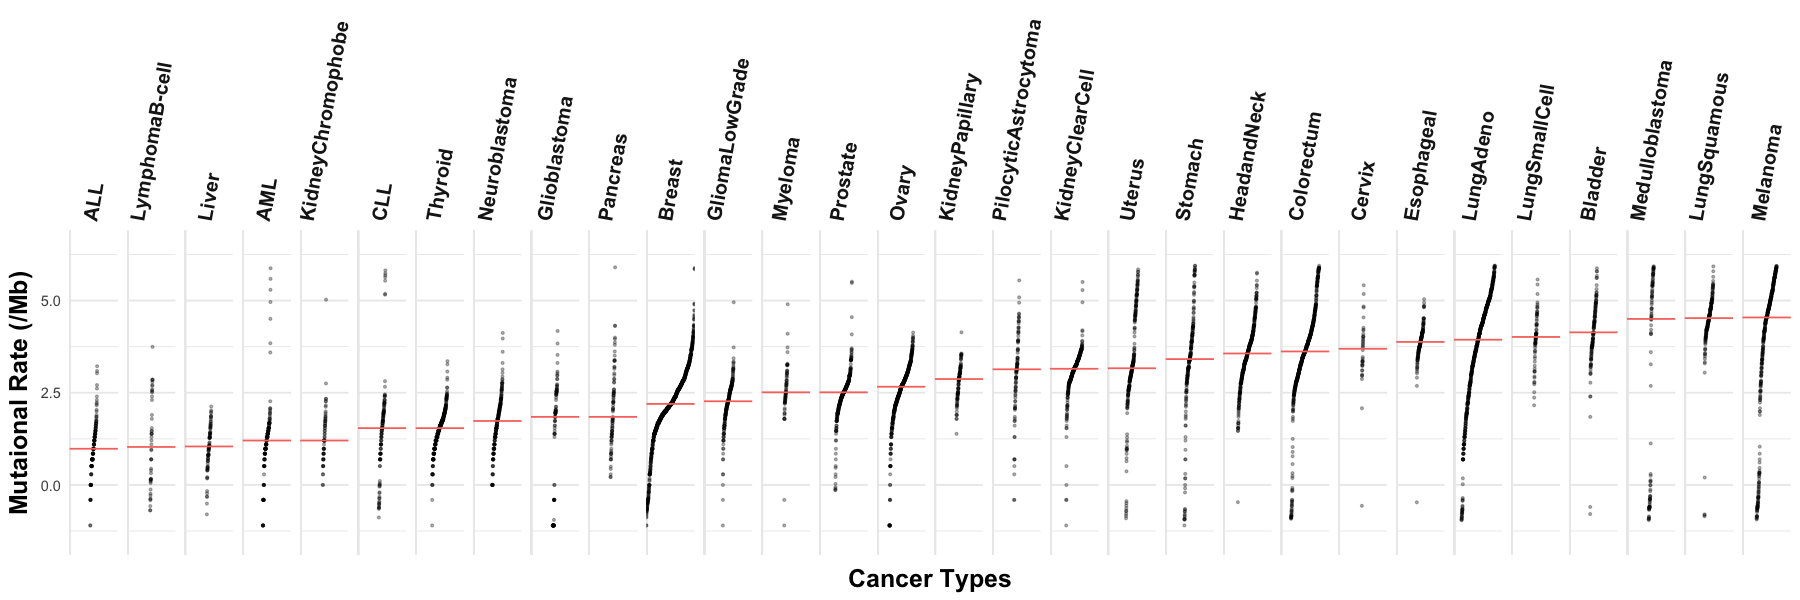

In [17]:
## plot the data:
options(repr.plot.width=15, repr.plot.height=5)
plot<-ggplot(plot_data,aes(order,sorted_MR,fill=cancer_order))+geom_point(size=0.5,alpha=0.3)+scale_x_discrete(limits=new_x_labels)
plot<-plot+theme_minimal()+theme(strip.text.x = element_text(angle = 80,face ="bold",size = 12, vjust = 0,hjust = 0.5))
plot<-plot+theme(axis.text.x=element_blank(),
                 axis.title.x=element_text(face ="bold",size = 15),
                 axis.title.y=element_text(face ="bold",size = 15),
                 legend.position="none")
plot<-plot+geom_hline(aes(yintercept=median_snvs, col = "red"))+ylab("Mutaional Rate (/Mb)")+ylim(-1.5,6.5)+ xlab("Cancer Types")
plot+facet_grid(~cancer_order)

#### Note

Due to lack of orignal records, the mutation rate is inferred by assigning each sample to WES or WGS based on the total snvs. Thus, there will be some results which are different with the published data.

#### Comment

The plot shows inter and intra heregenetity in the observed cancer patients.

#### Problem 1b: 
Visualise the mutational signatures downloaded from ["Signatures of Mutational Processes in Human Cancer"](http://cancer.sanger.ac.uk/cosmic/signatures), they are in the variable cosmic30.

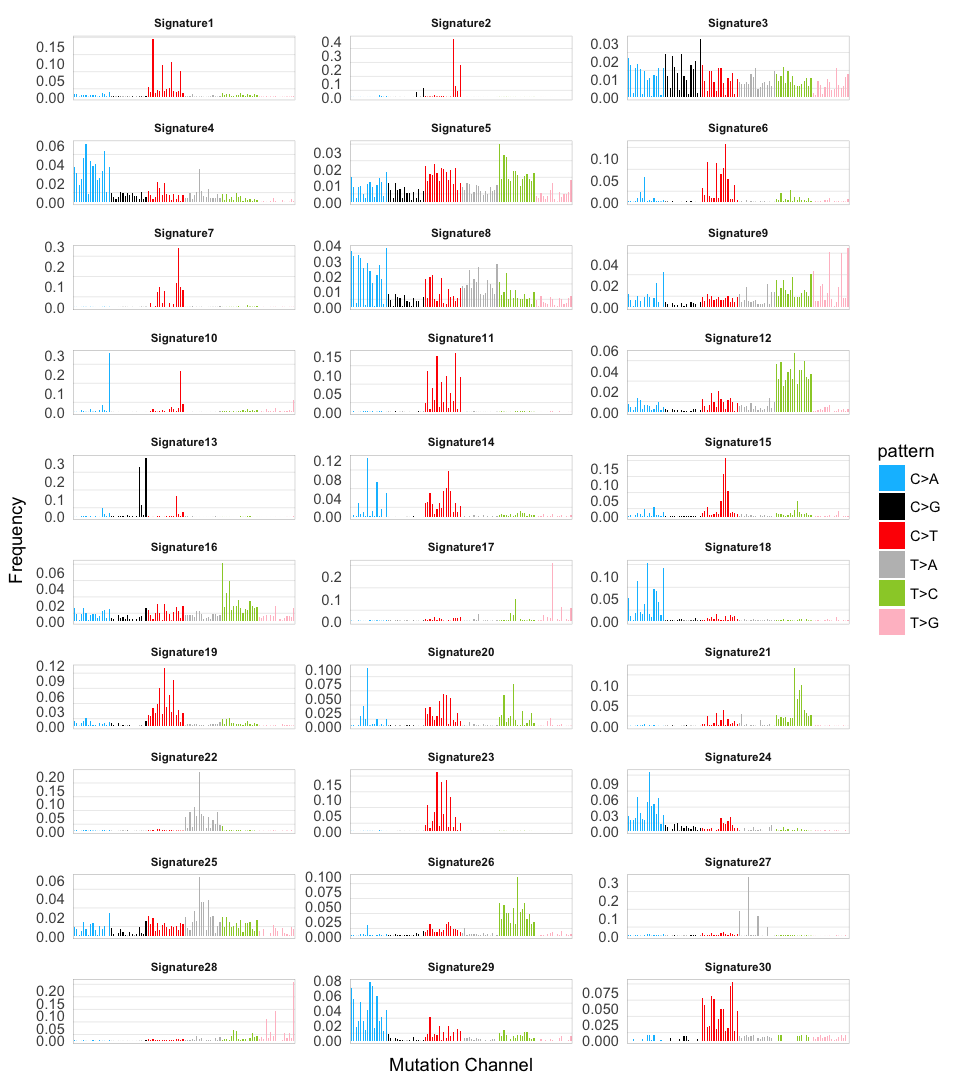

In [246]:
## trying to make a new data frame (sig_30) for plotting, which contains 1)name -> 30 signatures; 2)pattern -> six mutation types
## 3) context -> the 5' and 3' context for the mutations 4) order -> 1:96 channles order for each cancer type
## 5) count -> the mutation probability in each channel per signatuers.

name<-NULL
pattern<-NULL
order<-NULL
context<-NULL
count<-NULL

for (i in 1:30){
    name<-c(name,as.character(replicate(96,i)))
    pattern<-c(pattern,as.character(channels96$mutation.type))
    context<-c(context,as.character(channels96$mutation.context))
    order<-c(order,1:96)
    count<-c(count,as.vector(as.matrix(cosmic30[i,])))
}

sig_30<-data.frame(name=name,pattern=pattern,context=context,order=as.factor(order),count=count)
name<-rep("Signature",dim(sig_30)[1])
sig_30$name<-paste(name,sig_30$name,sep="")

sig_30$sig_order<-factor(sig_30$name,levels=as.vector(as.factor(paste("Signature",1:30,sep=""))))
#head(sig_30)
#head(cosmic30)

## plotting

color_scheme<-c("deepskyblue","black","red","grey","yellowgreen","pink")
options(repr.plot.width=8, repr.plot.height=9)
plot2<-ggplot(data=sig_30,aes(x=order,y=count,fill=pattern))+geom_bar(stat="identity",width=0.5,size=.5)
plot2<-plot2+theme_minimal()+theme( axis.text.x=element_blank(),
                                    axis.ticks.x=element_blank(),
                                    panel.grid.major=element_blank(),                                   
                                    panel.border = element_rect(colour = "black", fill=NA, size=0.1),
                                    strip.text.x = element_text(face ="bold",size = 7,vjust = 0,hjust = 0.5))

plot2<-plot2+scale_fill_manual(values=color_scheme)+xlab("Mutation Channel") +ylab("Frequency")
plot2+facet_wrap(~ sig_order,ncol=3,scale="free")

#### Problem 1c: 
Visualise average mutational count proportions per cancer type. So first normalise the counts for each sample by the number of muations within the sample. Then make an average of these mutation profiles within a cancer type. Make this both at the 96 mutation channel level as well as summing over the context so that only 6 mutational channels remain, (as they are listed in channels6). Can you see differences between cancer types? Use Figure 3 from Alexandrov et al to help look for cancer types that could look different when inspected via such average profiles. 

In [29]:
## make a copy of somaticMutations. and put the normalized values to somaticMutations_prop;
somaticMutations_prop<-somaticMutations
row_n<-dim(somaticMutations_prop)[1]
## calculte the normalized proportion in 96 channels for each cancer type replace the values in each channel:

#for(i in 1:row_n){
#    somaticMutations_prop[i,2:97]<- somaticMutations_prop[i,2:97]/somaticMutations_prop$total[i]
#}
total<-apply(somaticMutations_prop[,2:97],1,sum)
somaticMutations_prop[,2:97]<-apply(somaticMutations_prop[,2:97],2, function(x) x/total)
#summary
"The normalized 96-channel frequency in all cancer samples:"
head(somaticMutations_prop,2)
"To check if the total frequency will be sum up to 1 as expected:"
sum(somaticMutations_prop[23,2:97])

[1] "The normalized 96-channel frequency in all cancer samples:"

cancer_type,C>A@A_A,C>A@A_C,C>A@A_G,C>A@A_T,C>A@C_A,C>A@C_C,C>A@C_G,C>A@C_T,C>A@G_A,⋯,T>G@G_C,T>G@G_G,T>G@G_T,T>G@T_A,T>G@T_C,T>G@T_G,T>G@T_T,total,MutationalRate,order
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,-1.0986123,433
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,4,0.2876821,434


[1] "To check if the total frequency will be sum up to 1 as expected:"

[1] 1

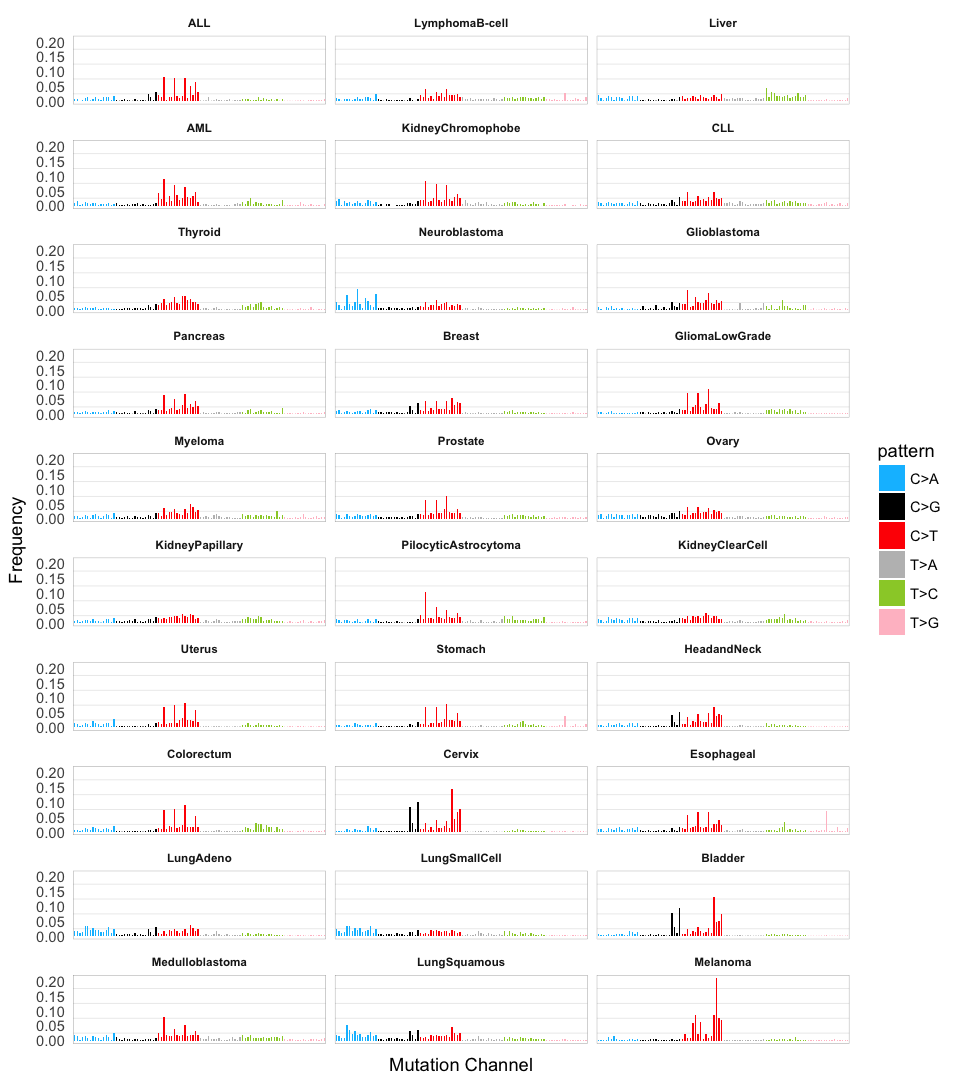

In [244]:
## Format the data for plot
mean_count<-NULL
prop_name<-NULL
prop_96_order<-NULL
prop_pattern<-NULL
prop_context<-NULL

## reminder: cancer_types_num<-length(cancer_uniq)
for (i in 1:cancer_types_num){## for each cancer type
    prop_name<-c(prop_name,replicate(96,as.character(cancer_uniq[i])))
    prop_96_order<-c(prop_96_order,1:96)
    prop_context<-c(prop_context,as.character(channels96$mutation.context))
    prop_pattern<-c(prop_pattern,as.character(channels96$mutation.type))
    
    cancer_logical_index<-somaticMutations$cancer_type == cancer_uniq[i]
    aa<-somaticMutations_prop[cancer_logical_index,2:97]    
    for (j in 1:96){
        mean_count<-c(mean_count,as.numeric(mean(aa[,j])))
    }
}
#class(mean_count)
normalized_cancer_data<-data.frame(cancer_type=prop_name,pattern=prop_pattern,context=prop_context,order=as.factor(prop_96_order),count=mean_count)
normalized_cancer_data$cancer_order<-factor(normalized_cancer_data$cancer_type,levels=as.vector(summary_data$cancer_type))

## for ploting:
options(repr.plot.width=8, repr.plot.height=9)
plot2<-ggplot(data=normalized_cancer_data,aes(x=order,y=count,fill=pattern))+geom_bar(stat="identity",width=0.5,size=.5)
plot2<-plot2+theme_minimal()+theme( axis.text.x=element_blank(),
                                    axis.ticks.x=element_blank(),
                                    panel.grid.major=element_blank(),                                   
                                    panel.border = element_rect(colour = "black", fill=NA, size=0.1),
                                    strip.text.x = element_text(face ="bold",size = 7,vjust = 0,hjust = 0.5))

plot2<-plot2+scale_fill_manual(values=color_scheme)+xlab("Mutation Channel") +ylab("Frequency")
plot2+facet_wrap(~ cancer_order,ncol=3)

### 6-channel plot in pancancer samples

In [31]:
## To make the data frame for 6-channel plot:

channel_6<-as.character(channels96$mutation.type)
channel_6<-unique(channel_6)
## the above two lines are the same as : channel_6<-c("C>A","C>G","C>T","T>A","T>C","T>G")
channel_6_length<-length(channel_6)
## Function to calculate the six-channel for a given cancer type and a mutation pattern
channel_6_sum<-function(cancer_type_index,pattern_index){
    cancer_type_temp<-cancer_uniq[cancer_type_index]
    pattern_temp<-channel_6[pattern_index]
    
    logical_cancer_data_index<-normalized_cancer_data$cancer_type==cancer_type_temp
    logical_pattern_data_index<-normalized_cancer_data$pattern==pattern_temp
    logical_16_channels_index<-logical_cancer_data_index & logical_pattern_data_index
    
    sum_one_of_6channels<-NULL
    
    if (sum(logical_16_channels_index)==16){
        sum_one_of_6channels<-sum(normalized_cancer_data$count[logical_16_channels_index])   
    }
    
    sum_one_of_6channels
}

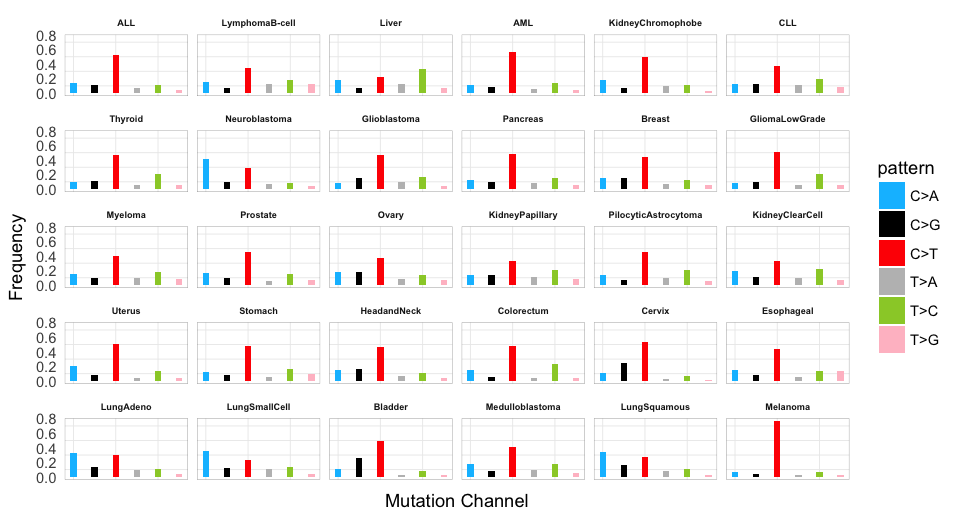

In [243]:
## to check the data number we have in the normalized_cancer_data is the same as we expected from the cancer types.
dim_of_6_channels<-dim(normalized_cancer_data)[1]/16
dim_of_6_channels_check<-cancer_types_num*6

if (dim_of_6_channels == dim_of_6_channels_check) {
    count_6channels<-NULL
    prop_name_6_channels<-NULL
    order_6_channels<-NULL
    pattern_6_channels<-NULL
    
   for(i in 1:cancer_types_num){
       prop_name_6_channels<-c(prop_name_6_channels,replicate(channel_6_length,as.character(cancer_uniq[i])))
       order_6_channels<-c(order_6_channels,as.factor(1:6))
       for(j in 1:channel_6_length){
            pattern_6_channels<-c(pattern_6_channels,as.character(channel_6[j]))
            sum_one_of_6channels<-as.numeric(channel_6_sum(i,j))
            count_6channels<-c(count_6channels,sum_one_of_6channels)
       }
   }
}
normalized_cancer_6channels<-data.frame(cancer_type=prop_name_6_channels,pattern=pattern_6_channels,order=order_6_channels,count=count_6channels)
normalized_cancer_6channels$cancer_order<-factor(normalized_cancer_6channels$cancer_type,levels=as.vector(summary_data$cancer_type))
#head(normalized_cancer_6channels)

## for plot:
options(repr.plot.width=8, repr.plot.height=4.3)
plot2<-ggplot(data=normalized_cancer_6channels,aes(x=order,y=count,fill=pattern))+geom_bar(stat="identity",width=0.3,size=.5)
plot2<-plot2+theme_minimal()+theme( axis.text.x=element_blank(),
                                    axis.ticks.x=element_blank(),
                                    panel.grid.major=element_blank(),                                   
                                    panel.border = element_rect(colour = "black", fill=NA, size=0.1),
                                    strip.text.x = element_text(face ="bold",size = 5.5,vjust = 0,hjust = 0.5))

plot2<-plot2+scale_fill_manual(values=color_scheme)+xlab("Mutation Channel") +ylab("Frequency")
plot2+facet_wrap(~ cancer_order,ncol=6)

#### Comment

We could find C>T mutation is a shared higly mutated type in all cancers. However, the total mutational spectrum are very different in the given cancers in both 6 or 96-channel profile. Additionally, C>A mutations are dominant in neuroblastoma and all lung cancers, e.g. LungAdeno, LungSamllCell and LungSquamous. Liver cancer is likely to carry T>G mutations from the above two figures.

The diverse mutation spectrum is probably due biased expousures to different mutational processes during a long time span. 

#### Problem 1d: 
Study now the signatures given. How different are they? Make a visualisation of all pairwise distances between the individual signatures. Use at least the following three metrics, cosine distance, Euclidian distance, Kullback-Leibler divergence. Use for visualisation heatmaps, c.f. Seaborn package, remember to add colour bars with a scale to all heat maps you plot. Make also figures where you plot all pairwise distances in an ordered way from most similar to least similar. Comment on how the change in the using distance/divergence measure affects this plot.  

In [33]:
## function to calculate cosine similarity:
cosine_similarity<-function(vectorA,vectorB){
    sum_AxB<-0
    sum_A2<-0
    sum_B2<-0
    
    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_AxB<-sum_AxB+vectorA[i,1]*vectorB[i,1]
            sum_A2<-sum_A2+vectorA[i,1]*vectorA[i,1]
            sum_B2<-sum_B2+vectorB[i,1]*vectorB[i,1]
        }
    }
    sum_AxB/(sqrt(sum_A2)*sqrt(sum_B2))
}

In [117]:
## function to calculate Euclidian distance:
Euclidian_distance<-function(vectorA,vectorB){
    sum_A_B_2<-0   
    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_A_B_2<-sum_A_B_2+(vectorA[i,1]-vectorB[i,1])**2
        }
    }
    sqrt(sum_A_B_2)
}

In [119]:
## function to calculate generalized Kullback-Leiber divergence:
KL_divergence<-function(vectorA,vectorB){
    sum_distance<-0    
    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            if (vectorA[i,1]>0 && vectorB[i,1]>0){ ## I only used non-zero values for calculation here.
                sum_distance<-sum_distance+log(vectorA[i,1]/vectorB[i,1])*vectorA[i,1]-vectorA[i,1]+vectorB[i,1]
            }          
        }
    }    
    sum_distance
}

In [247]:
## Function to call ditance matrix calculation based on given methods and the heatmap plotting:
simlarity_sig<-function(dataset,width,height,method){
    data<-as.matrix(dataset)
    number_sig<-dim(data)[2]
    
    dis_matrix<-matrix(replicate(number_sig*number_sig,0),ncol=number_sig) ## creat distance matrix
    
    max_divergence<-1; ## only used for KL_dist
    
    ## Fill up distance matrix for two given signatures. There are three methods could be applied (cosine,euclidian,KL)
    
    for (i in 1:number_sig){ ## fisrt loop
        pred_sig<-as.matrix(data[,i])
        for (j in 1:number_sig){ ## second loop
            picked_sig<-as.matrix(data[,j])
           
            if (method=="cosine"){
                dis_matrix[i,j]<-cosine_similarity(pred_sig,picked_sig) 
            
            }else if (method=="euclidian"){
                ## the 1-eulidian distance has been used in the distance matrix:
                dis_matrix[i,j]<-1-Euclidian_distance(pred_sig,picked_sig)
            
            }else if (method=="kl"){
                
                ## I calculate the KL divergence from a to b and then also b to a. The distance matrix use the sum.
                dist_a_b<-KL_divergence(pred_sig,picked_sig)
                dist_b_a<-KL_divergence(picked_sig,pred_sig)
                
                dis_matrix[i,j]<-dist_a_b+dist_b_a              
                
                if (dis_matrix[i,j]>max_divergence){
                    max_divergence<-dis_matrix[i,j] ## Find the maximum divergence for normalization:
                }
            }              
        }
    }
    
    if (method=="kl"){
        dis_matrix<-1-dis_matrix/max_divergence ## Normalize distance matrix for KL-dist
    }
    
    ## assign sig names:
    colnames(dis_matrix)<-colnames(dataset)
    rownames(dis_matrix)<-colnames(dataset)
    #print(dis_matrix)    
    hr <- hclust(dist(dis_matrix, method="manhattan"), method="average")
    ct<-cutree(hr, k=8)
    for (i in 1:8){
        print (paste("Cluster",i,":",sep=""))
        print (names(ct)[ct == i])
    }
    ## make dist matrix for headmap:
    dis_matrix_copy<-as.matrix(dis_matrix)    
    dis_matrix<- as.dist(as.matrix(dis_matrix))

    ## heatmap plotting:
    options(repr.plot.width=width, repr.plot.height=height)
    mycol <- colorpanel(40, "royalblue4","mistyrose","red4")
    if(method=="cosine"){
        heatmap.2(dis_matrix_copy, col=mycol,scale="none", density.info="none",key.xlab="Cosine Similarity", 
              trace="none",margins = c(3,3),key.title="",keysize = 1.2)
    }else if (method=="euclidian"){
        heatmap.2(dis_matrix_copy, col=mycol,scale="none", density.info="none",key.xlab="1-Euclidian_dist", 
              trace="none",margins = c(4,4),key.title="",keysize = 1.45)
    }else if(method =="kl"){
        heatmap.2(dis_matrix_copy, col=mycol,scale="none", density.info="none",key.xlab="1-KL_dist", 
              trace="none",margins = c(3,3),key.title="",keysize = 1.2)
    }    
}

In [248]:
cosmic30_t<-t(cosmic30)
colnames(cosmic30_t)<-paste("Sig",1:30,sep="")

[1] "Cluster1:"
[1] "Sig1"  "Sig6"  "Sig14" "Sig15" "Sig20"
[1] "Cluster2:"
[1] "Sig2"  "Sig13" "Sig22" "Sig27"
[1] "Cluster3:"
[1] "Sig3"  "Sig5"  "Sig8"  "Sig9"  "Sig16" "Sig25"
[1] "Cluster4:"
[1] "Sig4"  "Sig18" "Sig24" "Sig29"
[1] "Cluster5:"
[1] "Sig7"  "Sig11" "Sig19" "Sig23" "Sig30"
[1] "Cluster6:"
[1] "Sig10"
[1] "Cluster7:"
[1] "Sig12" "Sig21" "Sig26"
[1] "Cluster8:"
[1] "Sig17" "Sig28"


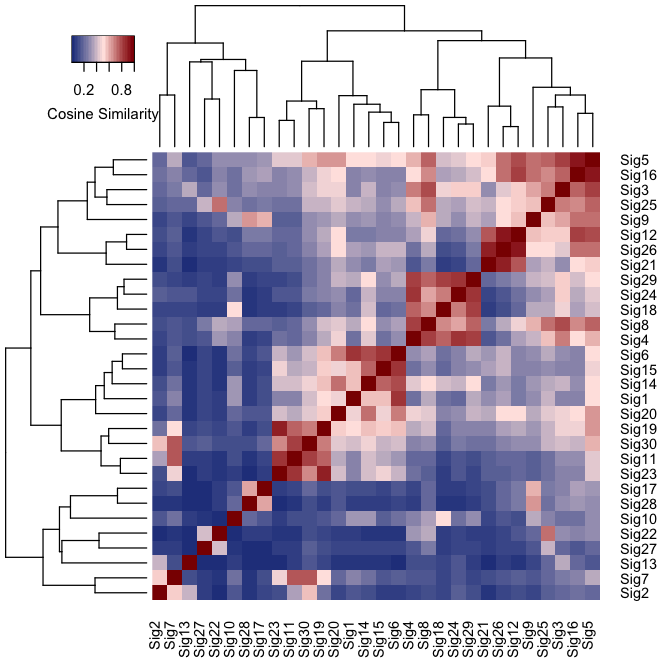

In [249]:
simlarity_sig(cosmic30_t,5.5,5.5,"cosine")


[1] "Cluster1:"
[1] "Sig1"  "Sig6"  "Sig14" "Sig15" "Sig19" "Sig21" "Sig30"
[1] "Cluster2:"
[1] "Sig2"  "Sig13"
[1] "Cluster3:"
 [1] "Sig3"  "Sig4"  "Sig5"  "Sig8"  "Sig9"  "Sig12" "Sig16" "Sig20" "Sig24"
[10] "Sig25" "Sig26" "Sig29"
[1] "Cluster4:"
[1] "Sig7"
[1] "Cluster5:"
[1] "Sig10" "Sig27"
[1] "Cluster6:"
[1] "Sig11" "Sig23"
[1] "Cluster7:"
[1] "Sig17" "Sig22" "Sig28"
[1] "Cluster8:"
[1] "Sig18"


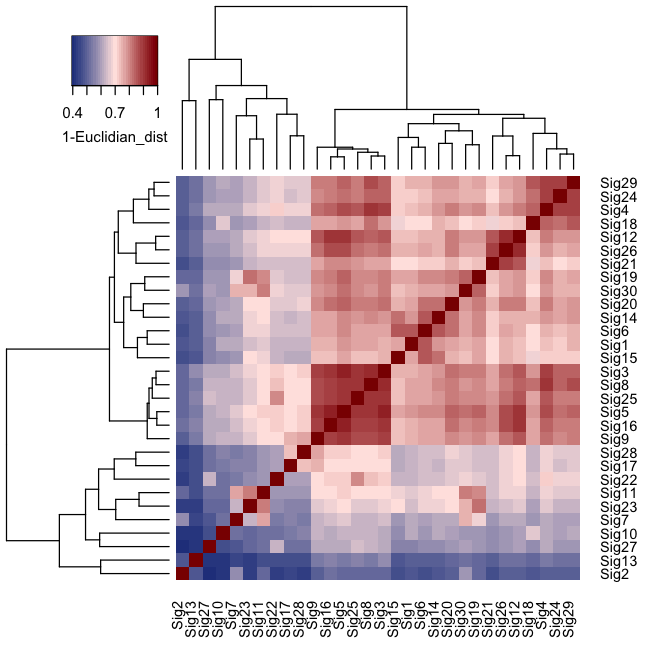

In [250]:
simlarity_sig(cosmic30_t,5.5,5.5,"euclidian")

[1] "Cluster1:"
[1] "Sig1"  "Sig6"  "Sig14" "Sig15" "Sig19" "Sig20" "Sig30"
[1] "Cluster2:"
[1] "Sig2"  "Sig13"
[1] "Cluster3:"
 [1] "Sig3"  "Sig4"  "Sig5"  "Sig8"  "Sig9"  "Sig16" "Sig18" "Sig24" "Sig25"
[10] "Sig29"
[1] "Cluster4:"
[1] "Sig7"  "Sig11" "Sig23"
[1] "Cluster5:"
[1] "Sig10"
[1] "Cluster6:"
[1] "Sig12" "Sig21" "Sig26"
[1] "Cluster7:"
[1] "Sig17" "Sig28"
[1] "Cluster8:"
[1] "Sig22" "Sig27"


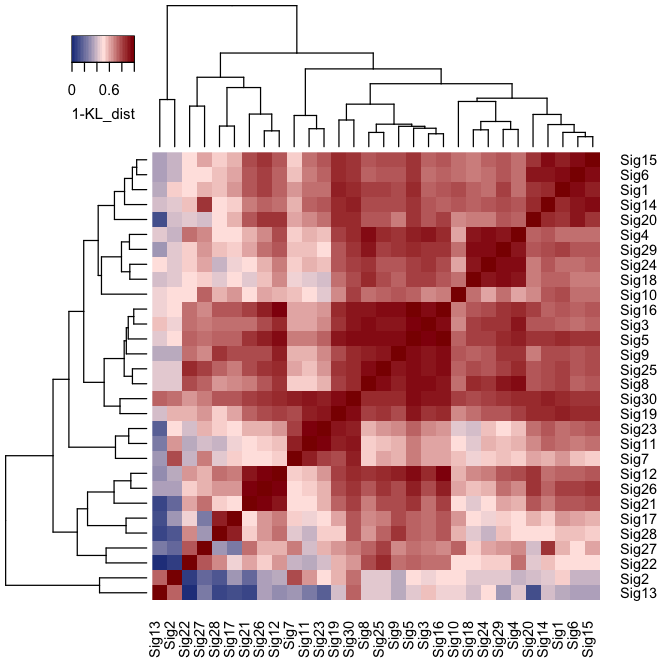

In [251]:
simlarity_sig(cosmic30_t,5.5,5.5,"kl")

#### Comment:

I clustered the known 30 mutational signatures released by COSMIC using cosine similarity, eucludian distance and Kullback-Leiber divergence. For all the three measurements, the distance matrix has been normalized to 0-1 level, and one represents the most similar two signatures. To comapre the cluster result, all 30 signatures have been assigned into 8 groups in each case.

As we could see from the above figures, to a certain extent, the three methods shared the same cluster results. For instance, Sig1, Sig6, Sig14 and Sig15 from group1, Sig2 and Sig13 from the group2, Sig3, Sig5, Sig8, Sig9, Sig16 and Sig25 from group3 and so on.

However, some signaturs have been assigned into different clusters by the three methods. Overall, the cluster based on cosine similarity and KL-divergence shared more similar results. e.g. Sig7, Sig 11 and Sig 23; Sig22 and Sig27; sig19 and Sig30. Thus, these two methods will be more suitable to measure the signature similarity.

There are also a few signatures they are clustered as one group but they are very different with other groups in general. e.g. sig2 and sig13


### Problem 2: Generate simulated data <a id='Problem1'></a>

#### Problem 2a: 
Use the instructions from lectures slides L1 together with the real signatures to make a function that allows you to simulate data under three different noise models, Poisson, Negative Binomial and Gaussian. Make three data sets, one for each model that you analyse below.

In [197]:
## It will produce a list, which contains:

## 1) only one simulated sample for the given arguments
## 2) the picked index of given cosmic signatures
## 3) the contribution of the used signatures 

simulate_mutational_process<-function(mean_activity_num=4,total_count=1000,cosmic=cosmic30,seed=1,model="poisson"){
    set.seed(seed)
    poisson_array<-round(rpois(30,mean_activity_num))
    constrains_activity_number<-dim(cosmic)[1]+1
    activity_num<-poisson_array[poisson_array>2 & poisson_array<constrains_activity_number][1]
    index_picked_sig<-sample(1:dim(cosmic)[1],size=activity_num,replace = F)

    ## pick the signatures from the cosmic30
    picked_sig<-cosmic[index_picked_sig,]
    #colnames(picked_sig)<-paste("channel",1:96,sep="_")
    
    ## generate the exposure weight vector based on dirichlet distribution:
    exposure_sig<-rdirichlet(1,1:activity_num)
    # print(exposure_sig)
    ## The picked signatures (96*activity_num) %*% the exposure matrix (activity_num*1)= the 96-channels for simulation.
    simulated_96_channels<-t(picked_sig) %*% t(exposure_sig) ## which should be sum up to 1
    #print (c("sum of W*H",sum(simulated_96_channels)))
    
    ## simulated_96_channels is the density over 96-channel, here it will get the absolute count of each channel:
    simulated_96_channels<-simulated_96_channels*total_count    
    
    ## For different models, here we add the noise count to the 96 channels 
    if (model=="poisson"){
        simulated_96_channels<-rpois(replicate(length(simulated_96_channels),1),simulated_96_channels)        
    }else if (model=="gaussian"){
        simulated_96_channels<-rnorm(replicate(length(simulated_96_channels),1),simulated_96_channels)
    }else if (model== "negativebinomial"){
        simulated_96_channels<-rnbinom(replicate(length(simulated_96_channels),1), mu = simulated_96_channels, size = total_count)
    }
    sig_contribution<-rep(0,length(index_picked_sig))
    for(i in 1:length(index_picked_sig)){
        sig_index<-index_picked_sig[i]
        if (sig_index %in% index_picked_sig){
            index_contribution<-match(sig_index,index_picked_sig)
            contribution<-exposure_sig[index_contribution]
        }else{
            contribution<-0
        }
        sig_contribution[i]<-contribution*total_count
    }
    
    output<-list(as.integer(simulated_96_channels),sort(index_picked_sig),sig_contribution)
    output
}


In [116]:
## Take the 96-channels of simiulated sample and visualize it:

## Note, the input data should be as.vector:

simulation_plot<-function(simulated_96_channels){
    simulated_data<-data.frame(channel=paste("channel",1:96,sep="_"),order=1:96,pattern=channels96$mutation.type,count=simulated_96_channels)
    options(repr.plot.width=7, repr.plot.height=2)
    color_scheme<-c("deepskyblue","black","red","grey","yellowgreen","pink")
    plot<-ggplot(data=simulated_data,aes(x=order,y=count,fill=pattern)) + geom_bar(stat="identity",width=0.5,size=.5)
    plot<-plot+theme_classic()+theme(axis.text.x=element_blank(),axis.ticks.x=element_blank()) + scale_fill_manual(values=color_scheme)
    plot<-plot+xlab("Mutation Channel") +ylab("Frequency")
    plot
}

[1] "Total mutation count: 2000"
[1] "Sum of simulated total count:" "2026"                         
[1] "Used model" "poisson"   
[1] "selected_signatures"


[1] 14 15 18

[1] "contributions of selected contributions"


[1]   61.01206  613.90491 1325.08303

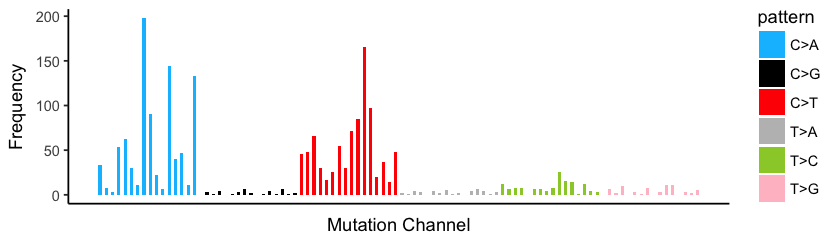

In [205]:
model<-"poisson"
simulation_test<-simulate_mutational_process(mean_activity_num=4,total_count=2000,
                                             cosmic=cosmic30,seed=1,model=model)
simulated_96_channels<-as.vector(simulation_test[[1]])

##plot
simulation_plot(simulated_96_channels)

##OUTPUT:
print ("Total mutation count: 2000")
print(c("Sum of simulated total count:", sum(simulated_96_channels)))
print (c("Used model",model))
print("selected_signatures")
simulation_test[[2]]
print("contributions of selected contributions")
simulation_test[[3]]

#### Problem 2b:
Make a scatter plot of the input model vs. simulated counts from the model (see for example in lecture slides L1) for each one of the noise models. Use log log scale, comment on what you see?

In [208]:
start_input<-10
end_input<-10**4
input_count<-start_input:end_input ## which will be used fot the input total count number
predict_count_p<-replicate(length(input_count),0) ##"Poisson"
predict_count_n<-replicate(length(input_count),0) ##"Negative Bionomial"
predict_count_b<-replicate(length(input_count),0) ##"Gaussian"

Model_name_p<-replicate(length(input_count),"Poisson noise")
Model_name_n<-replicate(length(input_count),"Gaussian noise")
Model_name_b<-replicate(length(input_count),"Negative bionomial noise")

for (i in 1:length(input_count)){
    input<-input_count[i]
    ## Poisson
    simulation_p<-simulate_mutational_process(mean_activity_num=4,total_count=input,
                                             cosmic=cosmic30,seed=input,model="poisson")
    predict_count_p[i]<-sum(simulation_p[[1]])
    
    ## Gaussian
    simulation_n<-simulate_mutational_process(mean_activity_num=4,total_count=input,
                                             cosmic=cosmic30,seed=input,model="gaussian")
    predict_count_n[i]<-sum(simulation_n[[1]])
    
    ##Negative Bionomial
    simulation_b<-simulate_mutational_process(mean_activity_num=4,total_count=input,
                                             cosmic=cosmic30,seed=input,model="negativebinomial")
    predict_count_b[i]<-sum(simulation_b[[1]])
}


Warning message in data.frame(input_count = log10(input_count), predict_count = log10(predict_count), :
“NaNs produced”Warning message:
“Removed 1 rows containing missing values (geom_point).”

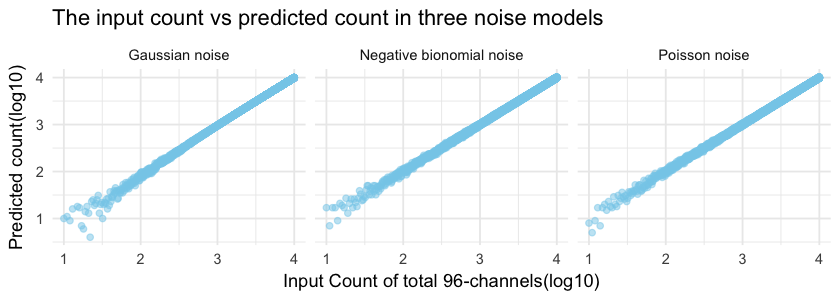

In [209]:
input_count<-start_input:end_input
models<-c(Model_name_p,Model_name_n,Model_name_b)
predict_count<-c(predict_count_p,predict_count_n,predict_count_b)
input_count<-c(input_count,input_count,input_count)
#length(models);length(predict_count);length(input_count)

predict_data<-data.frame(input_count=log10(input_count),predict_count=log10(predict_count),model=models)
#tail(predict_data)
options(repr.plot.width=7, repr.plot.height=2.5)
plot<-ggplot(predict_data,aes(input_count,predict_count,fill=model))+geom_point(col="skyblue",alpha=0.5,show.legend=F)
plot<-plot+facet_wrap(~ model,ncol=3)+theme_minimal()+ggtitle("The input count vs predicted count in three noise models")
plot+xlab("Input Count of total 96-channels(log10)")+ ylab("Predicted count(log10)")

#### Comment

Here, we simulated the mutation counts for 96-channel using different noise models. As we could see from the above plot, the input-predict mutation counts from all models converged very well when the input count is more than 100. In terms of input count less than 100, poisson and negative binomial noise model showed better consisitant prediction result.


#### Problem 2c:

For each simulated sample we know the underlying noise model. Form a log likelihood score for each sample to observe the data given that model. Note take the variance for Gaussian and the over dispersion for the Negative binomial as given and in their correct values rather than inferring them from the data, all models have the same mean for each mutational channel. Use all three models for each sample regardless of the fact that a sample was generated using just one of them. Do summary statistics over the samples and see if you can notice from the log likelihood under what noise model the data was generated. (Note we discuss this further on lecture 2).

In [172]:
simulate_model_likelihood<-function(mean_activity_num=4,total_count=1000,cosmic=cosmic30,seed=1){
    model<-sample(c("poisson","gaussian","negativebinomial"),1)
    set.seed(seed)
    poisson_array<-round(rpois(30,mean_activity_num))
    constrains_activity_number<-dim(cosmic)[1]+1
    activity_num<-poisson_array[poisson_array>2 & poisson_array<constrains_activity_number][1]
    index_picked_sig<-sample(1:dim(cosmic)[1],size=activity_num,replace = F)

    ## pick the signatures from the cosmic30
    picked_sig<-cosmic[index_picked_sig,]
    #colnames(picked_sig)<-paste("channel",1:96,sep="_")
    
    ## generate the exposure weight vector based on dirichlet distribution:
    exposure_sig<-rdirichlet(1,1:activity_num)
    # print(exposure_sig)
    ## The picked signatures (96*activity_num) %*% the exposure matrix (activity_num*1)= the 96-channels for simulation.
    simulated_96_channels<-t(picked_sig) %*% t(exposure_sig) ## which should be sum up to 1
    #print (c("sum of W*H",sum(simulated_96_channels)))
    
    ## simulated_96_channels is the density over 96-channel, here it will get the absolute count of each channel:
    simulated_96_channels<-as.integer(simulated_96_channels*total_count)  
    mean_simulation<-simulated_96_channels
    ## For different models, here we add the noise count to the 96 channels 
    if (model=="poisson"){
        simulated_96_channels<-rpois(replicate(length(simulated_96_channels),1),simulated_96_channels)        
    }else if (model=="gaussian"){
        simulated_96_channels<-rnorm(replicate(length(simulated_96_channels),1),simulated_96_channels)
    }else if (model== "negativebinomial"){
        simulated_96_channels<-rnbinom(replicate(length(simulated_96_channels),1), mu = simulated_96_channels, size = total_count)
    }
#    print (model)
    
    simulated_96_channels<-as.integer(simulated_96_channels)
    
    ## calculate the log likelihood in three models:
    log_likelihood_1<-0
    log_likelihood_2<-0
    log_likelihood_3<-0
    
    for (i in 1:length(simulated_96_channels)){
        prob_1<-dpois(simulated_96_channels[i],lambda=mean_simulation[i],log=T)
        if (prob_1 != "-Inf" ){
            log_likelihood_1<-log_likelihood_1+prob_1
        }
#        print (c(prob_1,mean_simulation[i],simulated_96_channels[i]))
        prob_2<-dnorm(simulated_96_channels[i], mean =mean_simulation[i], sd = 1,log = T)
        if (prob_2 != "-Inf" ){
            log_likelihood_2<-log_likelihood_2+prob_2
        }
        prob_3<-dnbinom(simulated_96_channels[i], size=total_count, mu=mean_simulation[i],log=T)
        if (prob_3 != "-Inf" ){
            log_likelihood_3<-log_likelihood_3+prob_3
        }
    }
    
    ## get the estimated model based on the largest likelihood value:
    estimated_model<-"none"
    if (log_likelihood_1>log_likelihood_2 & log_likelihood_1>log_likelihood_3){
        estimated_model<-"poisson"
    }else if(log_likelihood_2>log_likelihood_1 & log_likelihood_2>log_likelihood_3){
       estimated_model<-"gaussian"
    }else if (log_likelihood_3>log_likelihood_1 & log_likelihood_3>log_likelihood_1){
        estimated_model<-"negativebinomial"
    }
        
    list(mean_simulation,simulated_96_channels,model,log_likelihood_1,log_likelihood_2,log_likelihood_3,estimated_model)
}

In [173]:
sample<-paste("sample",1:10**4,sep="_")
known_model<-NULL
estimated_model<-NULL
poisson_LL<-NULL
gaussian_LL<-NULL
nb_LL<-NULL

for(i in 1:10**4){
    simulation<-simulate_model_likelihood(mean_activity_num=4,total_count=2000,cosmic=cosmic30,seed=i)
    known_model<-c(known_model,simulation[[3]])
    estimated_model<-c(estimated_model,simulation[[7]])
    poisson_LL<-c(poisson_LL,simulation[[4]])
    gaussian_LL<-c(gaussian_LL,simulation[[5]])
    nb_LL<-c(nb_LL,simulation[[6]])
#    print (c(i,simulation[[3]],simulation[[4]],simulation[[5]],simulation[[6]]))
#    print (c(i,simulation[[3]],simulation[[7]]))
}
simulation_model_estimation<-data.frame(sample=sample,known_model=known_model,estimated_model=estimated_model,
                                       poisson_LL=poisson_LL,gaussian_LL=gaussian_LL,negative_binomial_LL=nb_LL)


In [178]:
head(simulation_model_estimation,20)

sample,known_model,estimated_model,poisson_LL,gaussian_LL,negative_binomial_LL
sample_1,poisson,poisson,-198.5611,-660.2181,-198.7636
sample_2,gaussian,gaussian,-192.5046,-162.2181,-192.9368
sample_3,negativebinomial,poisson,-239.8648,-847.7181,-239.9856
sample_4,poisson,poisson,-243.8865,-761.7181,-244.0361
sample_5,poisson,negativebinomial,-236.6887,-1617.2181,-236.4382
sample_6,gaussian,gaussian,-214.8713,-158.2181,-215.3059
sample_7,negativebinomial,poisson,-222.0045,-551.2181,-222.2693
sample_8,poisson,poisson,-243.7434,-1035.7181,-243.7607
sample_9,negativebinomial,poisson,-241.9450,-937.7181,-242.0136
sample_10,gaussian,gaussian,-225.5261,-138.2181,-225.9753


In [175]:
total_p<-sum(simulation_model_estimation$known_model=="poisson")
correct_p<-sum(simulation_model_estimation$known_model=="poisson" & simulation_model_estimation$estimated_model=="poisson")
total_g<-sum(simulation_model_estimation$known_model=="gaussian")
correct_g<-sum(simulation_model_estimation$known_model=="gaussian" & simulation_model_estimation$estimated_model=="gaussian")
total_nb<-sum(simulation_model_estimation$known_model=="negativebinomial")
correct_nb<-sum(simulation_model_estimation$known_model=="negativebinomial" & simulation_model_estimation$estimated_model=="negativebinomial")

In [187]:
print(c("Sample size used poisson model",total_p,"correctly predicted:",correct_p,"Accuracy",round(correct_p/total_p,2)))

[1] "Sample size used poisson model" "3326"                          
[3] "correctly predicted:"           "1917"                          
[5] "Accuracy"                       "0.58"                          


In [188]:
print(c("Sample size used gaussian model",total_g,"correctly predicted:",correct_g,"Accuracy",round(correct_g/total_g,2)))

[1] "Sample size used gaussian model" "3306"                           
[3] "correctly predicted:"            "3276"                           
[5] "Accuracy"                        "0.99"                           


In [189]:
print(c("Sample size used NB model",total_nb,"correctly predicted:",correct_nb,
                                        "Accuracy",round(correct_nb/total_nb,2)))

[1] "Sample size used NB model" "3368"                     
[3] "correctly predicted:"      "1569"                     
[5] "Accuracy"                  "0.47"                     


In [195]:
mismatch_p_nb<-sum(simulation_model_estimation$known_model=="poisson" 
                       & simulation_model_estimation$estimated_model=="negativebinomial")

print(c("number of sample produced from poisson noise model predicted as from negativebinomial",mismatch_p_nb,
        "Percent of total poisson made samples",round(mismatch_p_nb/total_p,2)))

[1] "number of sample produced from poisson noise model predicted as negativebinomial"
[2] "1409"                                                                            
[3] "Percent of total poisson made samples"                                           
[4] "0.42"                                                                            


In [196]:
mismatch_nb_p<-sum(simulation_model_estimation$known_model=="negativebinomial" 
                       & simulation_model_estimation$estimated_model=="poisson")

print(c("number of sample produced from negativebinomial noise model predicted as from poisson",mismatch_nb_p,
        "Percent of total poisson made samples",round(mismatch_nb_p/total_nb,2)))

[1] "number of sample produced from negativebinomial noise model predicted as from poisson"
[2] "1799"                                                                                 
[3] "Percent of total poisson made samples"                                                
[4] "0.53"                                                                                 


#### Comment

The simulated samples with noise from negative binomial and poisson distribution shared very similar log likelihood, which represents these two models are very similar to each other. 